In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad
import einops

import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
import os
import glob
from symm_loss_defs import *
from decimal import Decimal

Using cuda device


In [4]:
#filename = "N_10000_hidden_size_100_layers_3_activation_GeLU_lr_0.0001_opt_Adam_data_seed_4810_train_seed_6244"
#filename = "N_10000_hidden_size_100_layers_3_activation_GeLU_lr_0.0001_opt_Adam_data_seed_2602_train_seed_3399"
#filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_0.0001_opt_Adam_data_seed_8981_train_seed_2668"
filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_1e-05_opt_Adam_data_seed_5927_train_seed_3643"
with open(f"./storage/{filename}.pkl","rb") as f:
    a = pickle.load(f)

In [3]:
def Lorentz_myfun(input):
        m2 = torch.einsum("... i, ij, ...j -> ...",input, torch.diag(torch.tensor([1.00,-1.00,-1.00,-1.00])).to(devicef), input)
        out = m2**2+15*m2
        return out.unsqueeze(1).to(devicef)

In [4]:
def Lorentz_myfun_broken(input,spurions = [torch.tensor([0,0,0,0])]):
    metric_tensor = torch.diag(torch.tensor([1.00,-1.00,-1.00,-1.00])).to(devicef)
    m2 = torch.einsum("... i, ij, ...j -> ...",input, metric_tensor, input)
    breaking_scalars = [torch.einsum("... i, ij, ...j -> ...",spurion.to(devicef), metric_tensor, input) for spurion in spurions]
    coeffs = [20.9983, -23.2444, 3.0459, 12.7176, -17.4378, 1.4378, 10.1877,15.8890, -11.5178,  -4.3926]
    coeffs_2 = [-0.8431,   5.7529,  19.0048,   3.2927, -14.9460,   5.6997,  -5.9202, -10.5052, 2.6883, 16.5809]
    symm_out = m2**2+15*m2
    out = symm_out
    for i in range(len(breaking_scalars)):
        out += coeffs[i%len(coeffs)]*breaking_scalars[i]+coeffs_2[i%len(coeffs_2)]*breaking_scalars[i]**2
    return out.unsqueeze(1).to(devicef)

In [5]:
 def pred_plot_ext(analysis,data,model = "last",save = False, outdir = "./",filename = ""):
        inputs = analysis.train_data.to(devicef)
        plt.clf()
        fig = {}
        if model == "last":
            models = analysis.models
            ext = ""
        elif model== "symm":
            models = analysis.models_best_symm
            ext = "_best_symm"
        elif model == "MSE":
            models = analysis.models_best_MSE
            ext = "_best_MSE"
        elif model == "tot":
            models = analysis.models_best_tot
            ext = "_best_tot"
            
        for lam_val in analysis.models.keys():
            plt.clf()
            fig[lam_val] = plt.figure()
            plt.scatter(analysis.train_labels.cpu().squeeze(),models[lam_val](inputs).detach().cpu().squeeze(),label = rf"$\lambda$ = {lam_val} training data")
            plt.scatter(Lorentz_myfun(data).cpu().squeeze(),models[lam_val](data).detach().cpu().squeeze(),label = rf"$\lambda$ = {lam_val} new data",color = "pink",alpha = 0.2)
            plt.plot(Lorentz_myfun(data).cpu().squeeze(),Lorentz_myfun(data).cpu().squeeze(),color = "black")
            plt.legend()
            plt.xlabel("truth")
            plt.ylabel("pred")
            err = ((Lorentz_myfun(data).cpu().squeeze()-models[lam_val](data).detach().cpu().squeeze())**2).mean()
            #err = '%.4E' % Decimal("f{err}")
            err = "{:.4e}".format(err)
            mse = analysis.train_loss_lam[lam_val][-1]
            mse = "{:.4e}".format(mse)
            symm = analysis.symm_loss_lam[lam_val][-1]
            symm = "{:.4e}".format(symm)
            text = f"lam = {lam_val}, var = {err} MSE = {mse}, symm = {symm}"
            print(text)
            text = f"var = {err}, MSE = {mse}, symm = {symm}"
            plt.text(-9, -10,text)
            
            if save==True or save=="True":
                if filename =="":
                    file = f"plot_pred{ext}_lam_{lam_val}_{analysis.filename}"
                else:
                    file = filename
                fig[lam_val].show()
                fig[lam_val].savefig(f"{outdir}/plot_pred_lam_{lam_val}_{file}_{analysis.filename}.pdf")
            plt.show()
                #plt.close(fig[lam_val])


In [6]:
def Lorentz_Trans(data,beta):
    gamma = 1/np.sqrt(1-beta**2)
    LorentzBoost = torch.tensor([[gamma, -gamma*beta,  0, 0],[-gamma*beta, gamma, 0, 0],[0,0,1,0],[0,0,0,1]],dtype = torch.float32).to(devicef)
    trans_data = torch.einsum("ij,...j-> ...i",LorentzBoost,data).to(devicef)
    return trans_data

In [7]:
def rot(data,theta):
    
    rotate = torch.tensor([[1, 0,  0, 0],[0, np.cos(theta), np.sin(theta), 0],[0,-np.sin(theta),np.cos(theta),0],[0,0,0,1]],dtype = torch.float32).to(devicef)
    trans_data = torch.einsum("ij,...j-> ...i",rotate,data).to(devicef)
    return trans_data

In [8]:
Nnew = 1000
norm = 1.5
new_data  = (torch.rand(Nnew,4)-0.5)*norm
new_data = new_data.to(devicef)

In [60]:
broken = Lorentz_myfun_broken(new_data,spurions = [torch.tensor([0.0,0.0,0.0,1.0]).to(devicef)])

In [42]:
broken[0:5]

tensor([[  4.2883],
        [-33.8803],
        [-11.0179],
        [  7.3941],
        [-10.7246]], device='cuda:0')

In [40]:
unbroken = Lorentz_myfun(new_data)
unbroken[0:5]

tensor([[ -1.6463],
        [-17.8151],
        [ -4.4678],
        [ -1.3248],
        [ -3.8621]], device='cuda:0')

In [9]:
mymodelLorentz = broken_model(dinput = 4, init = "eta",spurions = [torch.tensor([0.0,0.0,0.0,1.0]).to(devicef)])

In [12]:
lossLorentz = SymmLoss(gens_list=gens_Lorentz, model = mymodelLorentz)

In [13]:
loss_res = lossLorentz(input = new_data)

In [14]:
loss_res

tensor(41.7690, device='cuda:0', grad_fn=<MeanBackward0>)

In [23]:
lossLorentz_Lz_Kx_Ky = SymmLoss(gens_list=gens_Lorentz[[0,1,-1]], model = mymodelLorentz)
loss_res_Lz_Kx_Ky = lossLorentz_Lz_Kx_Ky(input = new_data)
loss_res_Lz_Kx_Ky

tensor(6.7241e-14, device='cuda:0', grad_fn=<MeanBackward0>)

In [7]:
trans_new_data = Lorentz_Trans(data = a.train_data.to(devicef),beta = 0.6)

NameError: name 'a' is not defined

In [ ]:
rot_data = rot(data = a.train_data.to(devicef),theta = 0.5)

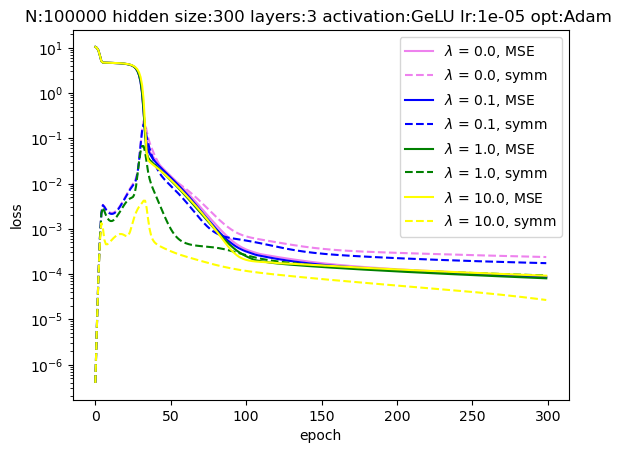

In [23]:
a.plot_losses()

In [24]:
for key in a.train_loss_lam.keys():
    print(f"lam = {key} current MSE loss = {np.min(a.train_loss_lam[key][-1])}")
    print(f"lam = {key} current sym loss = {np.min(a.symm_loss_lam[key][-1])}")
for key in a.train_loss_lam.keys():
    print(f"lam = {key} min MSE loss = {np.min(a.train_loss_lam[key])}")
    print(f"lam = {key} min sym loss = {np.min(a.symm_loss_lam[key])}")


lam = 0.0 current MSE loss = 8.878582753823139e-05
lam = 0.0 current sym loss = 0.0002377936485572718
lam = 0.1 current MSE loss = 8.509340790624264e-05
lam = 0.1 current sym loss = 0.00017425142621505074
lam = 1.0 current MSE loss = 8.057760816882365e-05
lam = 1.0 current sym loss = 9.313061862485483e-05
lam = 10.0 current MSE loss = 9.195333979732822e-05
lam = 10.0 current sym loss = 2.6713794122770197e-05
lam = 0.0 min MSE loss = 8.878582753823139e-05
lam = 0.0 min sym loss = 3.944802807609449e-07
lam = 0.1 min MSE loss = 8.509340790624264e-05
lam = 0.1 min sym loss = 3.944672863553933e-07
lam = 1.0 min MSE loss = 8.057760816882365e-05
lam = 1.0 min sym loss = 3.9435104454810243e-07
lam = 10.0 min MSE loss = 9.195333979732822e-05
lam = 10.0 min sym loss = 3.9318858298997837e-07


N =100,000

lam = 0.0, var = 1.3795e-04 MSE = 8.8786e-05, symm = 2.3779e-04


<Figure size 640x480 with 0 Axes>

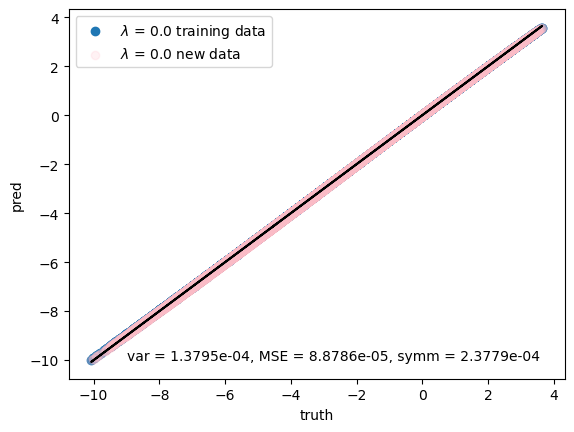

lam = 0.1, var = 1.2720e-04 MSE = 8.5093e-05, symm = 1.7425e-04


<Figure size 640x480 with 0 Axes>

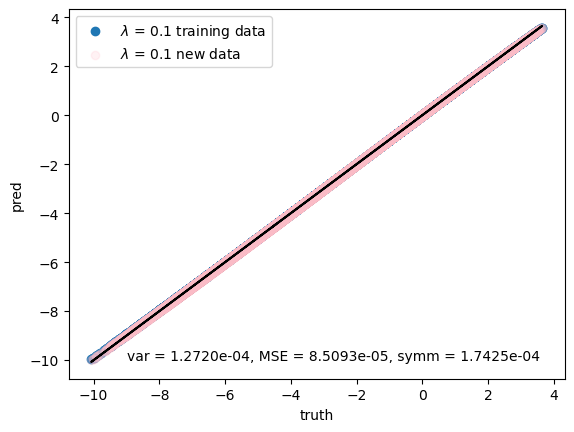

lam = 1.0, var = 8.7832e-05 MSE = 8.0578e-05, symm = 9.3131e-05


<Figure size 640x480 with 0 Axes>

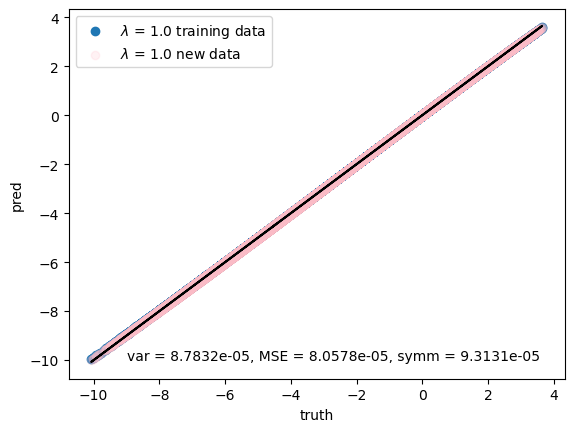

lam = 10.0, var = 8.9994e-05 MSE = 9.1953e-05, symm = 2.6714e-05


<Figure size 640x480 with 0 Axes>

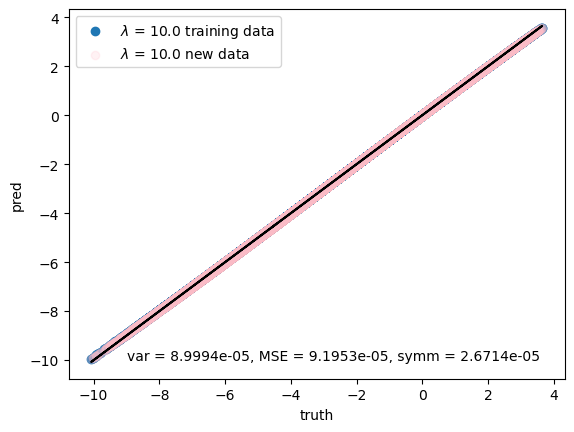

In [67]:
pred_plot_ext(a,rot_data,save = True, outdir = "./plots",filename = f"rot_0.5")

lam = 0.0, var = 1.1673e-02 MSE = 8.8786e-05, symm = 2.3779e-04


<Figure size 640x480 with 0 Axes>

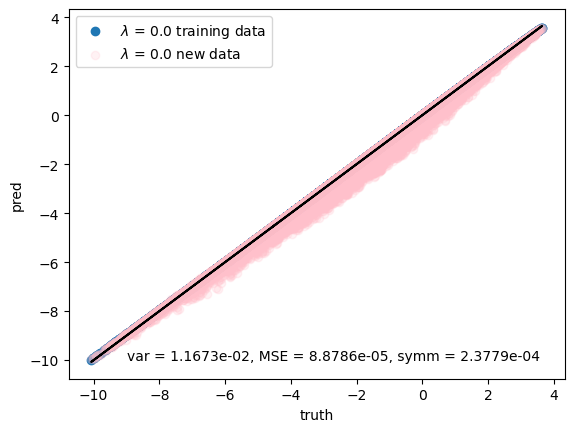

lam = 0.1, var = 6.9460e-03 MSE = 8.5093e-05, symm = 1.7425e-04


<Figure size 640x480 with 0 Axes>

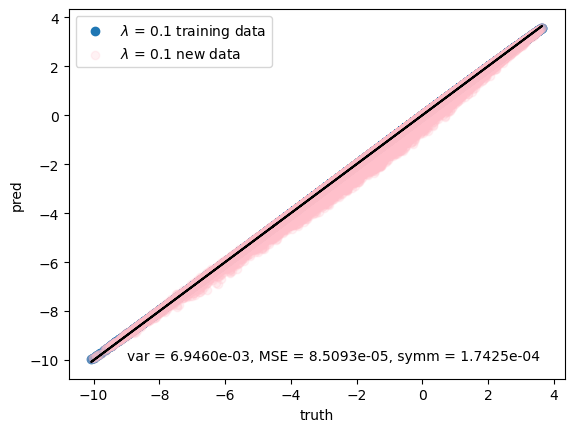

lam = 1.0, var = 2.8520e-03 MSE = 8.0578e-05, symm = 9.3131e-05


<Figure size 640x480 with 0 Axes>

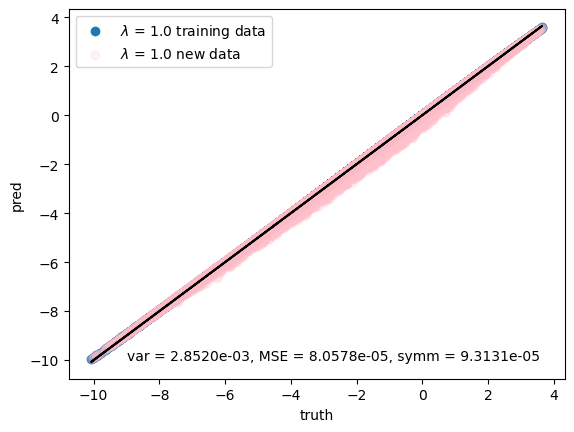

lam = 10.0, var = 1.3649e-03 MSE = 9.1953e-05, symm = 2.6714e-05


<Figure size 640x480 with 0 Axes>

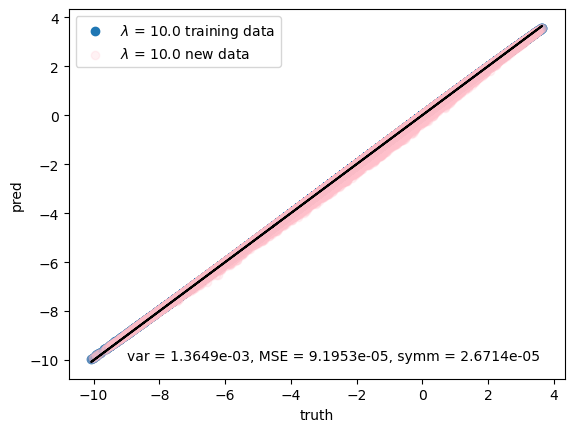

In [68]:
pred_plot_ext(a,trans_new_data,save = True, outdir = "./plots",filename = "boost_0.6")

N = 10,000

lam = 0.0, var = 0.00015094094851519912


<Figure size 640x480 with 0 Axes>

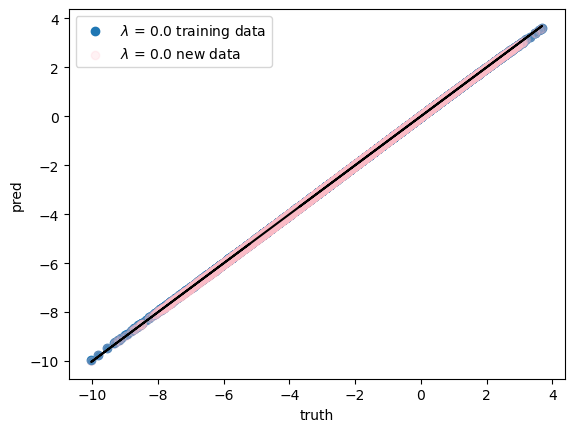

lam = 0.1, var = 0.00013319314166437835


<Figure size 640x480 with 0 Axes>

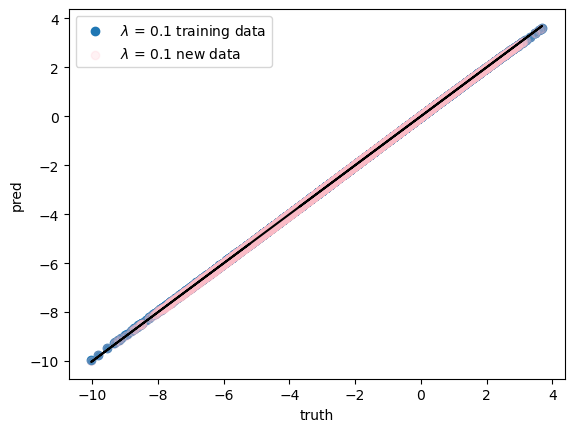

lam = 1.0, var = 0.00013627174485009164


<Figure size 640x480 with 0 Axes>

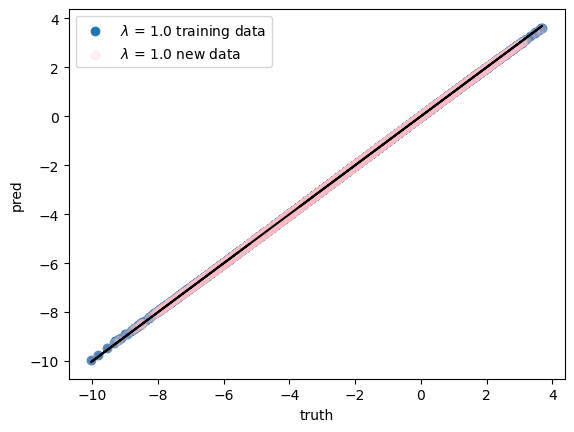

In [14]:
pred_plot_ext(a,rot_data,save = False, outdir = "./",filename = "")

lam = 0.0, var = 0.010359273292124271


<Figure size 640x480 with 0 Axes>

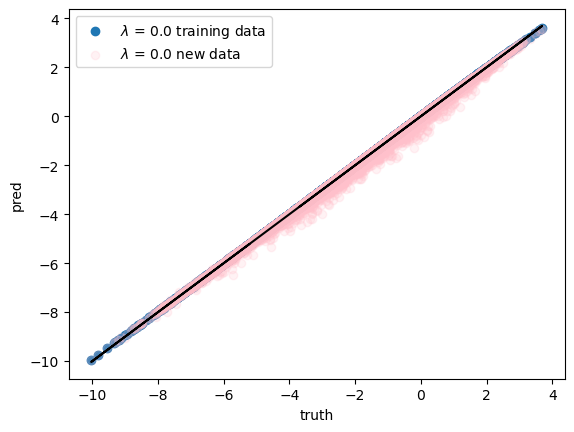

lam = 0.1, var = 0.00585052790120244


<Figure size 640x480 with 0 Axes>

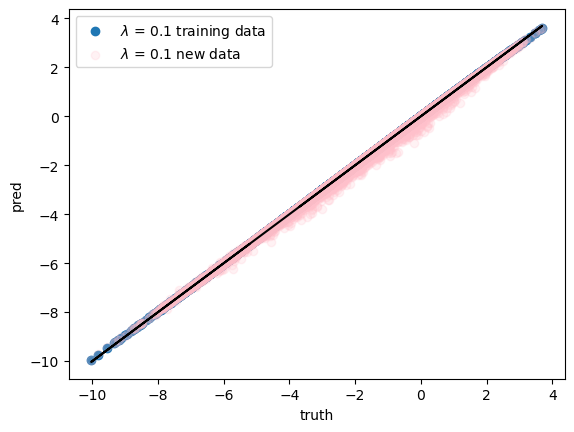

lam = 1.0, var = 0.0021061820443719625


<Figure size 640x480 with 0 Axes>

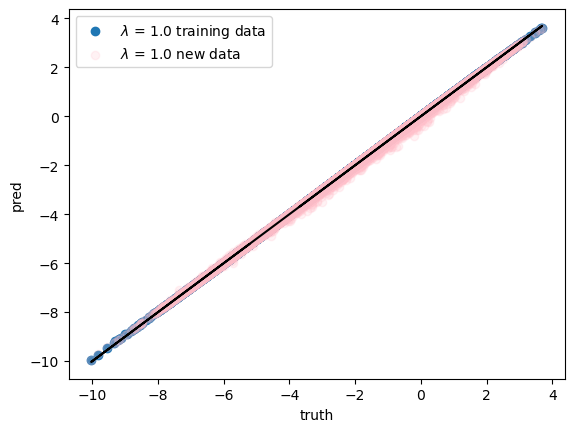

In [19]:
pred_plot_ext(a,trans_new_data,save = False, outdir = "./",filename = "")

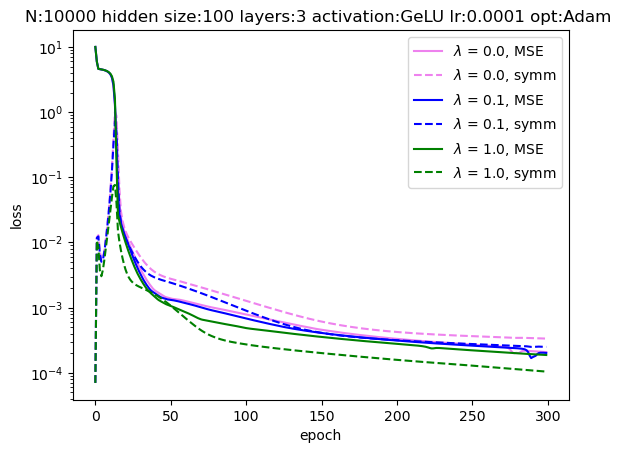

In [20]:
a.plot_losses(save = False, outdir = "./",filename = "")

Bi-linear layer symm loss

In [12]:
filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_5e-05_opt_Adam__bi-linear_layerdata_seed_3458_train_seed_727"
with open(f"./storage/{filename}.pkl","rb") as f:
    a = pickle.load(f)

lam = 0.0, var = 1.3637e-07 MSE = 8.3547e-06, symm = 2.8536e-08


<Figure size 640x480 with 0 Axes>

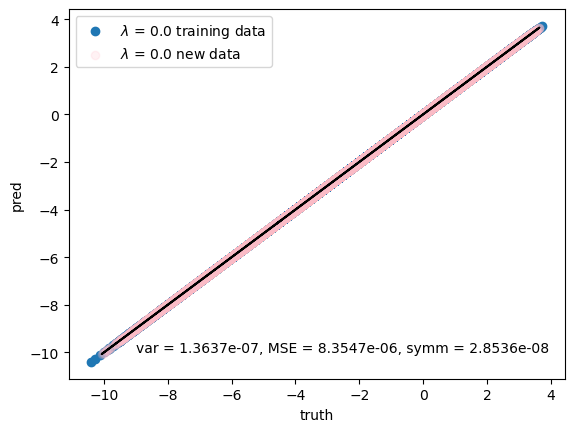

lam = 0.1, var = 1.1419e-06 MSE = 9.0331e-06, symm = 2.2076e-09


<Figure size 640x480 with 0 Axes>

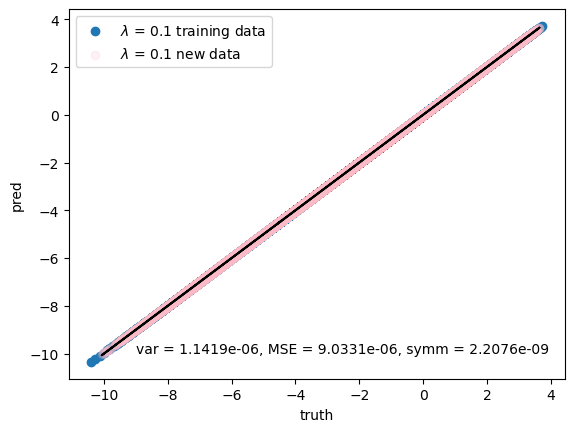

lam = 1.0, var = 5.1279e-06 MSE = 7.9266e-06, symm = 2.7267e-09


<Figure size 640x480 with 0 Axes>

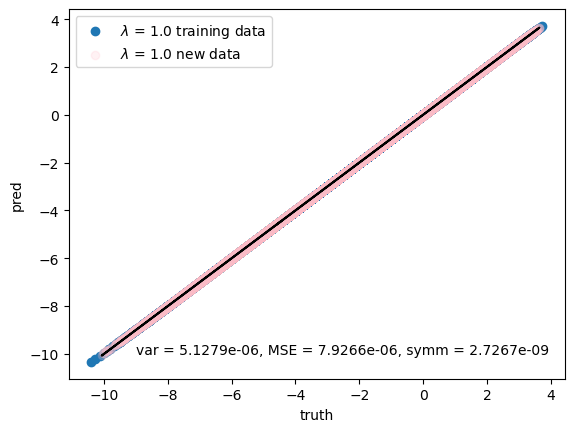

lam = 10.0, var = 8.2862e-06 MSE = 9.4689e-06, symm = 7.7038e-10


<Figure size 640x480 with 0 Axes>

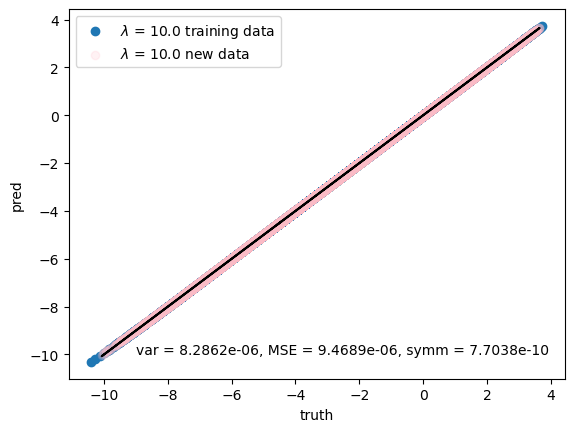

In [14]:
pred_plot_ext(a,rot_data,save = True, outdir = "./plots",filename = f"rot_0.5")

lam = 0.0, var = 1.3467e-07 MSE = 8.3547e-06, symm = 2.8536e-08


<Figure size 640x480 with 0 Axes>

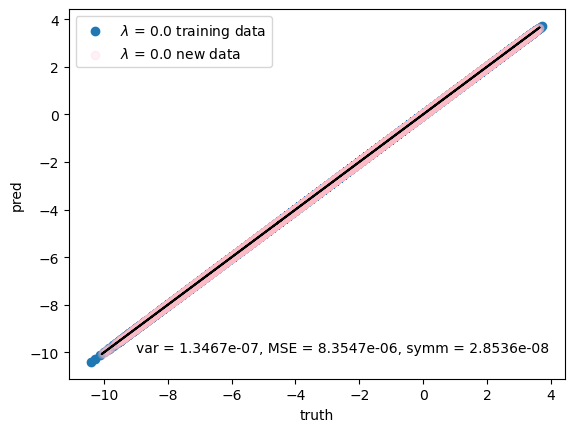

lam = 0.1, var = 1.1288e-06 MSE = 9.0331e-06, symm = 2.2076e-09


<Figure size 640x480 with 0 Axes>

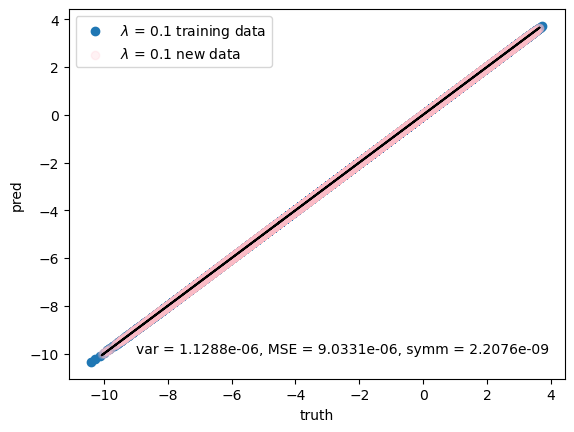

lam = 1.0, var = 5.0549e-06 MSE = 7.9266e-06, symm = 2.7267e-09


<Figure size 640x480 with 0 Axes>

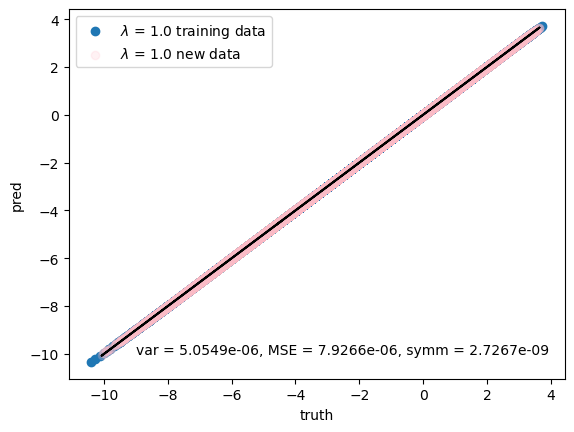

lam = 10.0, var = 8.3456e-06 MSE = 9.4689e-06, symm = 7.7038e-10


<Figure size 640x480 with 0 Axes>

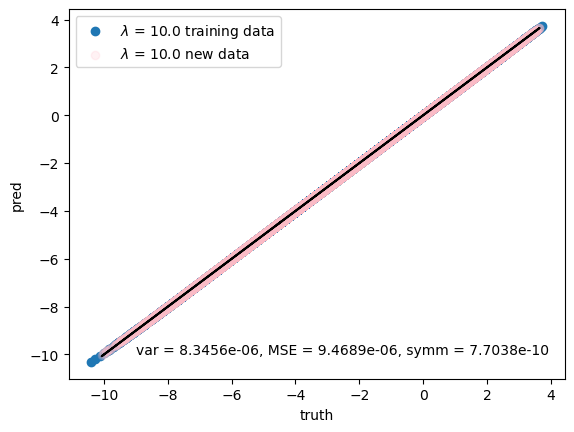

In [15]:
pred_plot_ext(a,trans_new_data,save = True, outdir = "./plots",filename = "boost_0.6")

With normalization

In [43]:
filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_5e-05_opt_Adam__bi-linear_layerdata_seed_3458_train_seed_727"
with open(f"./storage/{filename}.pkl","rb") as f:
    a = pickle.load(f)

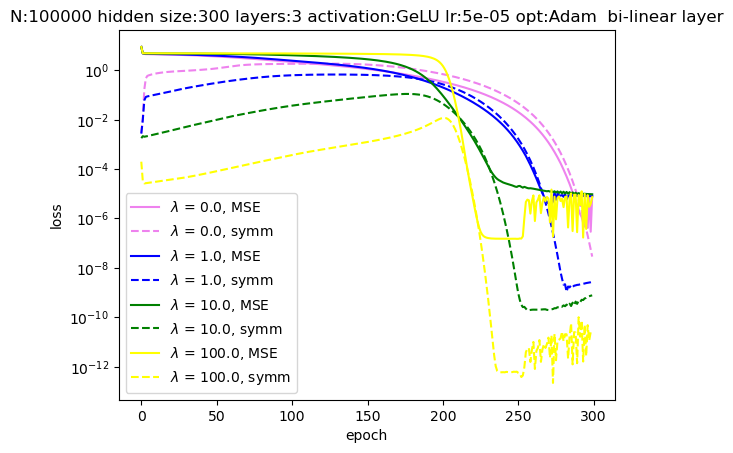

In [9]:
a.plot_losses(save = False, outdir = "./",filename = "")

In [10]:
a.symm_norm

'False'

In [9]:
class SymmLoss_norm_debug(nn.Module):

    def __init__(self, gens_list,model,device = devicef):
        super(SymmLoss_norm_debug, self).__init__()
        
        self.model = model.to(device)
        self.device = device
        # Initialize generators (in future add different reps for inputs?)
        self.generators = einops.rearrange(gens_list, 'n w h -> n w h')
        self.generators = self.generators.to(device)
        

    
    def forward(self, input, model_rep='scalar',norm = "none"):
        
        input = input.clone().detach().requires_grad_(True)
        input = input.to(self.device)
        # Compute model output, shape [B]
        output = self.model(input)

        # Compute gradients with respect to input, shape [B, d*N], B is the batch size, d is the input irrep dimension, N is the number of particles
        grads, = torch.autograd.grad(outputs=output, inputs=input, grad_outputs=torch.ones_like(output, device=self.device), create_graph=True)
        
        grads_norm = torch.einsum('... N, ... N -> ...', grads, grads)
        #print(grads_norm.mean())
        
        # Reshape grads to [B, N, d] 
        grads = einops.rearrange(grads, '... (N d) -> ... N d',d = self.generators.shape[-1])

        # Contract grads with generators, shape [n (generators), B, N, d]
        gen_grads = torch.einsum('n h d, ... N h->  n ... N d ',self.generators, grads)
        # Reshape to [n, B, (d N)]
        gen_grads = einops.rearrange(gen_grads, 'n ... N d -> n ... (N d)')

        # Dot with input [n ,B]
        differential_trans = torch.einsum('n ... N, ... N -> n ...', gen_grads, input)
        
       
        
        # scalar_loss = (differential_trans ** 2).mean()
        # print(f"symm loss = {scalar_loss}")
        
        scalar_loss_norm = (1/len(self.generators))*(torch.sum(differential_trans**2,dim = 0)/grads_norm).mean()
            
        return scalar_loss_norm,grads,grads_norm


In [7]:
filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_5e-05_opt_Adam__bi-linear_layer_normdata_seed_3458_train_seed_727"
with open(f"./storage/{filename}.pkl","rb") as f:
    a = pickle.load(f)

In [10]:
Lorentz_loss_norm = {}
grads = {}
grads_norm = {}
for key in a.models.keys():
    loss = SymmLoss_norm_debug(gens_list=gens_Lorentz, model = a.models[key])
    Lorentz_loss_norm[key],grads[key],grads_norm[key]  = loss(a.train_data)

In [11]:
for key in grads_norm.keys():
    print(f"lambda = {key}:")
    print(f"min gard^2 = {min(grads_norm[key])}")
    print(f"max gard^2 = {max(grads_norm[key])}")
    print(f"mean grad^2 = {grads_norm[key].mean()}")

lambda = 0.0:
min gard^2 = 0.9617189168930054
max gard^2 = 737.723876953125
mean grad^2 = 283.9656066894531
lambda = 100:
min gard^2 = 0.9615445733070374
max gard^2 = 738.0885009765625
mean grad^2 = 283.9857482910156
lambda = 1000.0:
min gard^2 = 0.9625749588012695
max gard^2 = 738.3421020507812
mean grad^2 = 283.98919677734375
lambda = 10000.0:
min gard^2 = 0.9606664776802063
max gard^2 = 736.69873046875
mean grad^2 = 283.3349914550781
lambda = 100000.0:
min gard^2 = 0.9612112045288086
max gard^2 = 738.4191284179688
mean grad^2 = 284.0018615722656


In [12]:
Lorentz_loss_norm

{0.0: tensor(1.4240e-13, device='cuda:0', grad_fn=<MulBackward0>),
 100: tensor(1.2397e-12, device='cuda:0', grad_fn=<MulBackward0>),
 1000.0: tensor(2.3168e-14, device='cuda:0', grad_fn=<MulBackward0>),
 10000.0: tensor(8.7121e-12, device='cuda:0', grad_fn=<MulBackward0>),
 100000.0: tensor(1.8517e-13, device='cuda:0', grad_fn=<MulBackward0>)}

lam = 0.0, var = 1.7645e-08 MSE = 4.2603e-08, symm = 3.5853e-12


<Figure size 640x480 with 0 Axes>

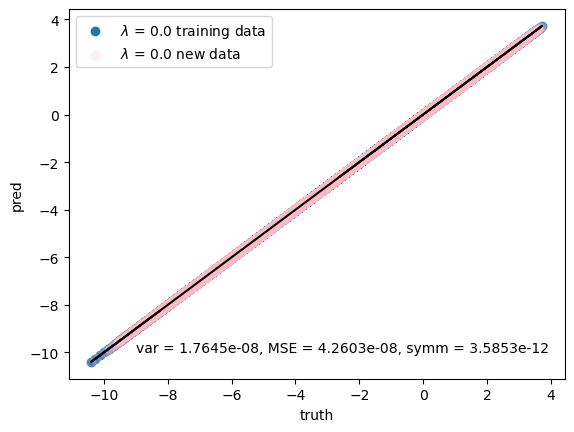

lam = 100, var = 2.1105e-08 MSE = 3.0074e-06, symm = 3.6831e-11


<Figure size 640x480 with 0 Axes>

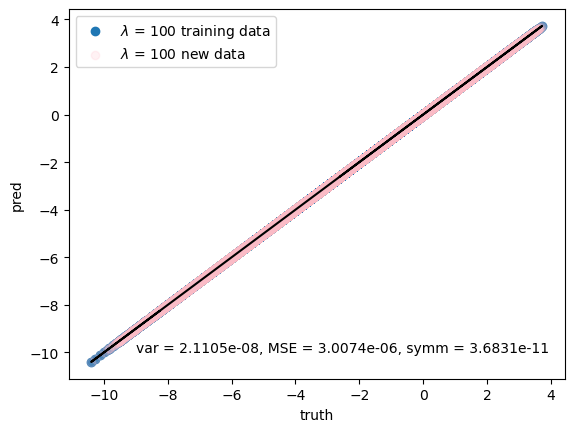

lam = 1000.0, var = 1.9130e-08 MSE = 3.5340e-08, symm = 2.2936e-13


<Figure size 640x480 with 0 Axes>

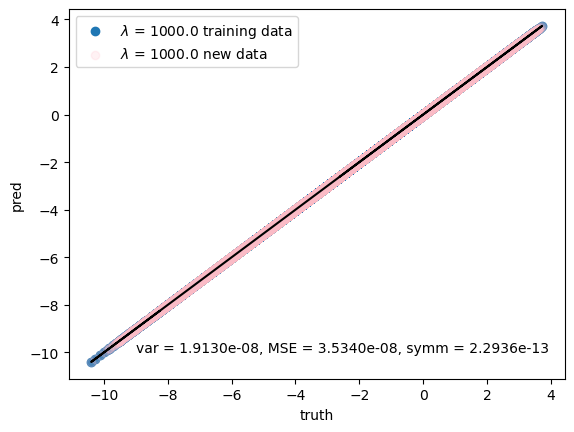

lam = 10000.0, var = 2.3534e-08 MSE = 2.3393e-06, symm = 1.6781e-13


<Figure size 640x480 with 0 Axes>

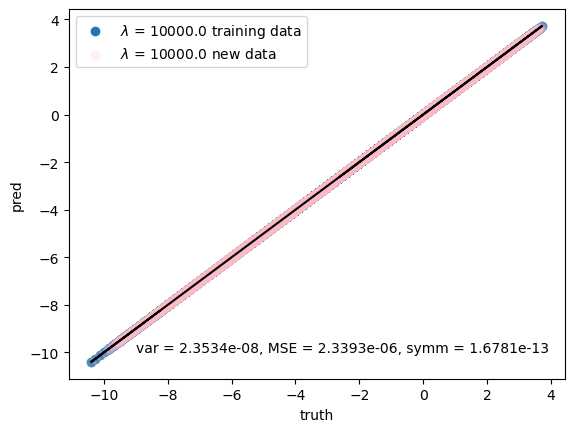

lam = 100000.0, var = 2.1610e-08 MSE = 8.0215e-06, symm = 4.2191e-13


<Figure size 640x480 with 0 Axes>

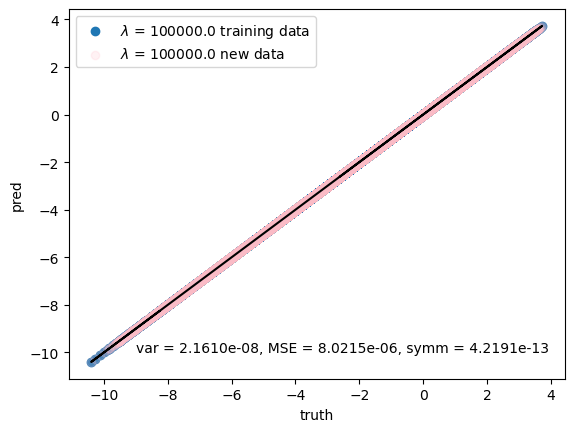

lam = 0.0, var = 1.7450e-08 MSE = 4.2603e-08, symm = 3.5853e-12


<Figure size 640x480 with 0 Axes>

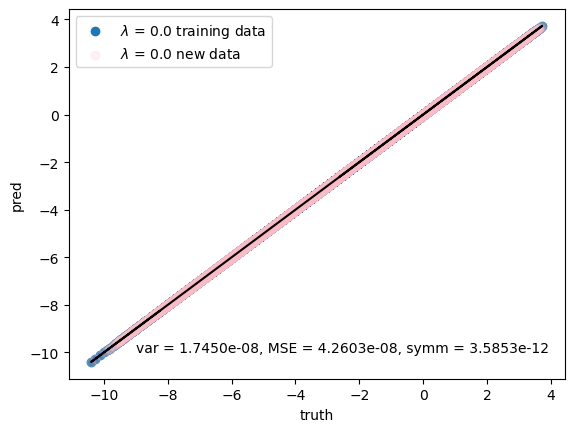

lam = 100, var = 2.1208e-08 MSE = 3.0074e-06, symm = 3.6831e-11


<Figure size 640x480 with 0 Axes>

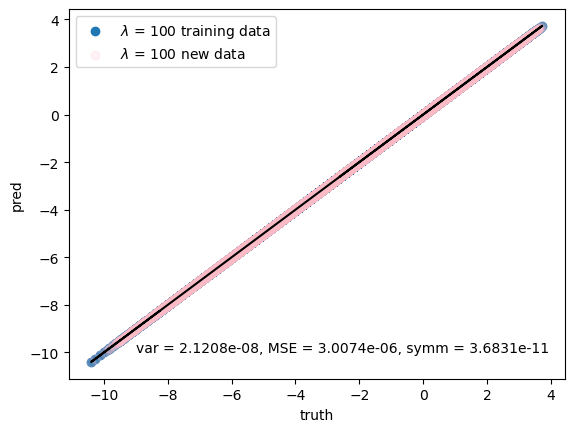

lam = 1000.0, var = 1.9139e-08 MSE = 3.5340e-08, symm = 2.2936e-13


<Figure size 640x480 with 0 Axes>

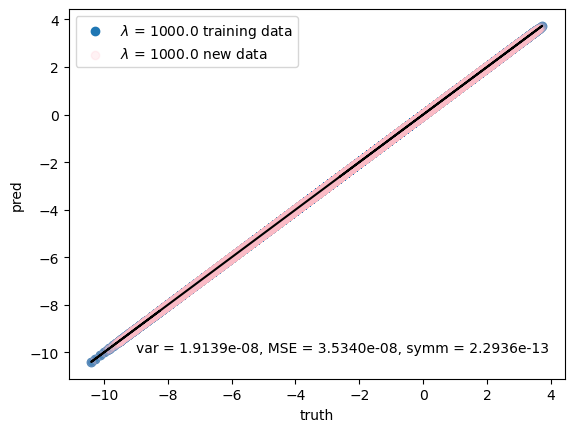

lam = 10000.0, var = 2.3544e-08 MSE = 2.3393e-06, symm = 1.6781e-13


<Figure size 640x480 with 0 Axes>

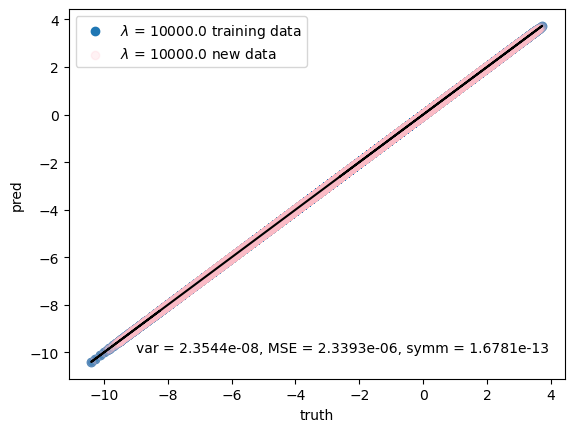

lam = 100000.0, var = 2.1605e-08 MSE = 8.0215e-06, symm = 4.2191e-13


<Figure size 640x480 with 0 Axes>

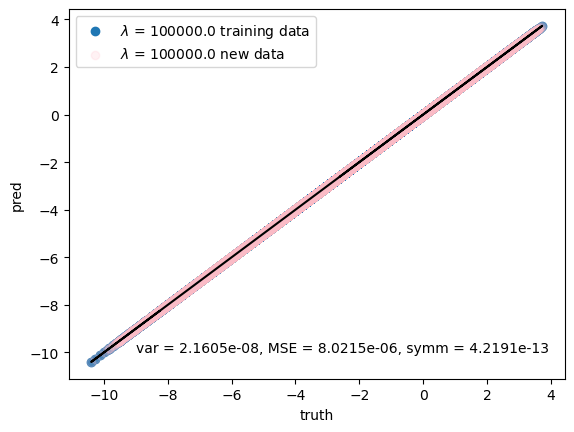

In [20]:
trans_new_data = Lorentz_Trans(data = a.train_data.to(devicef),beta = 0.6)
rot_data = rot(data = a.train_data.to(devicef),theta = 0.5)
pred_plot_ext(a,rot_data,model = "MSE", save = True, outdir = "./plots",filename = f"rot_0.5")
pred_plot_ext(a,trans_new_data,model = "MSE",save = True, outdir = "./plots",filename = "boost_0.6")